In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

# Helper Functions

In [2]:
def find_chessboard_corners(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    return ret, corners

In [3]:
def undistort_image(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

In [4]:
def calibrate_camera(visualization=True):
    # Read all camera calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Arrays to store object points and image points from all calibration images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points like (0,0,0), (1,0,0), (2,0,0), ... , (8,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y co-ordinates

    for fname in images:
        image = mpimg.imread(fname)
        h, w, c = image.shape

        # Find chessboard corners
        ret, corners = find_chessboard_corners(image)

        # If corners are found add object points and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    # Calibrate camera using above calculated object and image points
    r, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (h, w), None, None)
    
    if(visualization):
        image = mpimg.imread(images[13])
        
        # Find chessboard corners
        ret, corners = find_chessboard_corners(image)
        
        # Draw and display corners on last image for visualization
        image_with_corners = cv2.drawChessboardCorners(image, (9, 6), corners, ret)
    
        # Try undistorting the first image to make sure that the camera is calibrated properly
        undistort = undistort_image(image, mtx, dist)
        
        plt.figure(1, figsize=(15,5))
        plt.subplot(121)
        plt.title("Distorted image with corners")
        plt.imshow(image_with_corners)
        plt.subplot(122)
        plt.title("Undistorted image with corners")
        plt.imshow(undistort)
        plt.savefig("output_images/camera_calibration.jpg")
        plt.show()
    
    return mtx, dist

In [5]:
# Returns color_binary or binary based on what is supplied in the output_mode flag. Default value is binary.
def color_and_gradient_thresholding(image, s_thresh=(170, 255), sx_thresh=(20, 100), output_mode='binary'):
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    if (output_mode == 'binary'):
        binary = np.zeros_like(sxbinary)
        binary[(sxbinary == 1) | (s_binary == 1)] = 1
        return binary
    elif (output_mode == 'color_binary'):
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
        return color_binary

In [6]:
def birds_eye_transform(image, mtx, dist, showROI=True):
    h, w = image.shape[:2]
    
    src_points = np.float32([[(w/8), h], [(w/8)*7, h], [(w/8)*3.7, h/1.6], [(w/8)*4.3, h/1.6]])
    dst_points = np.float32([[(w/5), h], [(w/5)*4, h], [(w/5), 0], [(w/5)*4, 0]])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    warped = cv2.warpPerspective(image, M, (w, h), flags=cv2.INTER_LINEAR)
    
    if(showROI == True):
        c1 = plt.Circle(src_points[0], 5, color=(1, 0, 0))
        c2 = plt.Circle(src_points[1], 5, color=(1, 0, 0))
        c3 = plt.Circle(src_points[2], 5, color=(1, 0, 0))
        c4 = plt.Circle(src_points[3], 5, color=(1, 0, 0))

        # Open new figure
        fig = plt.figure(figsize=(15,10))
        # In figure, Image as background
        plt.imshow(image, cmap='gray')
        # Add the circles to figure as subplots
        fig.add_subplot(111).add_artist(c1)
        fig.add_subplot(111).add_artist(c2)
        fig.add_subplot(111).add_artist(c3)
        fig.add_subplot(111).add_artist(c4)
        plt.title("Region of Interest (Shown by red dots)")
        plt.savefig("output_images/region_of_interest.jpg")
        plt.show()
    
    return warped, M, Minv

In [7]:
def detect_lane(warped, xm_per_pix, first_image = False, abnormal_threshold=200):
    global left_fit, right_fit
    global leftx, lefty, rightx, righty
    global prev_left_fitx, prev_right_fitx, prev_out_img
    global abnormal_count
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[(int)(binary_warped.shape[0]/2):,:], axis=0)
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    if(first_image == True) or (abnormal_count > abnormal_threshold):
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Update previous values for the first time
    if (first_image):
        prev_left_fitx = left_fitx.copy()
        prev_right_fitx = right_fitx.copy()
        prev_out_img = out_img.copy()
    
    # Check distance between the two polynomials and count number of abnormal pixels
    abnormal_count = 0
    for i in range(len(left_fitx)):
        distance = (right_fitx[i] - left_fitx[i]) * xm_per_pix
        if (distance <= 0) or (distance > 4.2) or (distance < 3.2):
            abnormal_count += 1
            
    # If the number of abnormal pixels exceeds a threshold then use the previously detected line
    if (abnormal_count > abnormal_threshold):
        left_fitx = prev_left_fitx.copy()
        right_fitx = prev_right_fitx.copy()
        out_img = prev_out_img.copy()
    else:
        prev_left_fitx = left_fitx.copy()
        prev_right_fitx = right_fitx.copy()
        prev_out_img = out_img.copy()
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty

In [8]:
def get_radius_of_curvature(xm_per_pix, ym_per_pix):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    radius_of_curvature = min(left_curverad, right_curverad)
    
    return radius_of_curvature

In [9]:
def get_vehicle_position(xm_per_pix, ym_per_pix):
    car_center = ((right_fitx[-1] * xm_per_pix) - (left_fitx[-1] * xm_per_pix))/2
    actual_center = 3.7/2
    difference = abs(car_center - actual_center)
    
    if (left_fitx[-1] > (1280 - right_fitx[-1])):
        direction = 'left'
    elif (left_fitx[-1] < (1280 - right_fitx[-1])):
        direction = 'right'
    else:
        direction = 'center'

    return difference, direction

In [10]:
def get_output(undistorted_image):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_image.shape[1], test_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    return result

# Pipeline:
Step 1: Calibrate Camera

Step 2: Undistort images

Step 3: Color and Gradient Thresholding

Step 4: Perspective Transformation

Step 5: Detect lane pixels and fit to find the lane boundary

Step 6: Radius of Curvature

Step 7: Vehicle position

Step 8: Warp the detected lane boundaries back onto the original image

# Demonstration

## Step 1: Calibrate Camera

The very first step of the pipeline is to calibrate the camera as we do not want to work with distorted images. Here the user can simply call the calibrate camera function that goes through all 20 camera calibration images of the chessboard and returns the camera matrix and distortion coefficients. The user can switch on/off the visualization by passing a boolean parameter (True/False) to this function (the default value is True).

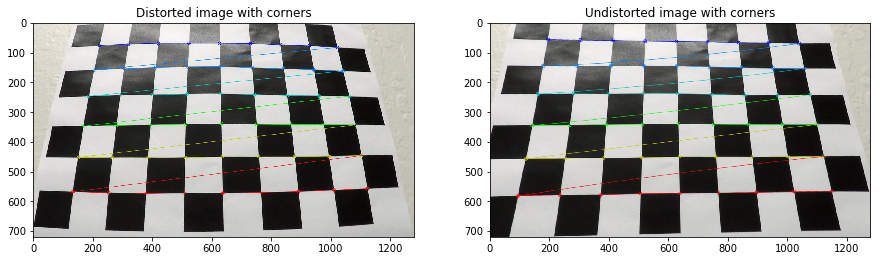

In [11]:
mtx, dist = calibrate_camera(True)

## Step 2: Undistort images

Now that we have the camera matrix and the distortion coefficients, we can easily read and undistort our images. An example is shown below: 

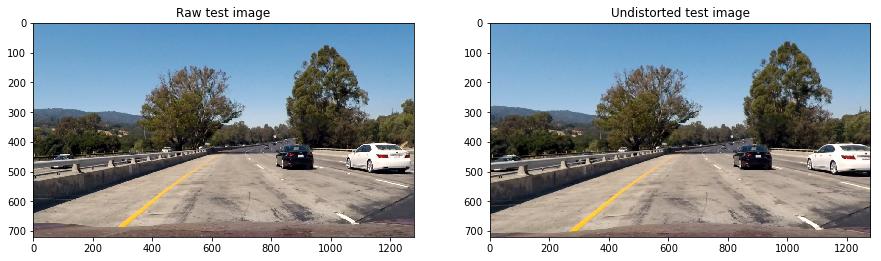

In [12]:
# Read a test image
test_image = mpimg.imread('test_images/test1.jpg')
undistort_test_image = undistort_image(test_image, mtx, dist)

plt.figure(1, figsize=(15,5))
plt.subplot(121)
plt.title("Raw test image")
plt.imshow(test_image)
plt.subplot(122)
plt.title("Undistorted test image")
plt.imshow(undistort_test_image)
plt.savefig("output_images/undistorted_image.jpg")
plt.show()

## Step 3: Color and Gradient Thresholding

Now we can apply a combination of color and gradient thresholding to detect the lane lines more efficiently. Here we work in the HLS (Hue, Lightness and Saturation) color space as we can very easily isolate the L part in order to make our detection algorithm independent of lighting conditions.

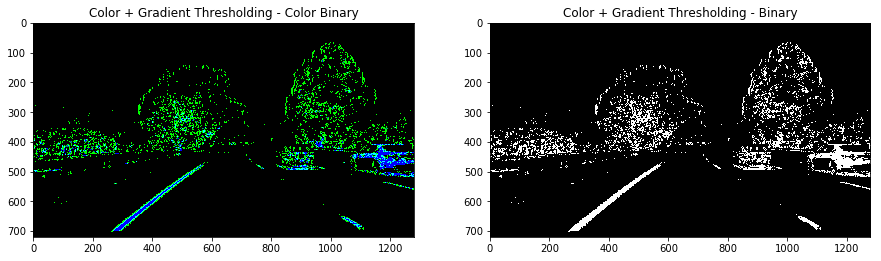

Green: Output of Gradient Thresholding
Blue: Output of Color Thresholding


In [13]:
color_binary = color_and_gradient_thresholding(undistort_test_image, output_mode='color_binary')
binary = color_and_gradient_thresholding(undistort_test_image, output_mode='binary')

plt.figure(2, figsize=(15,5))
plt.subplot(121)
plt.title("Color + Gradient Thresholding - Color Binary")
plt.imshow(color_binary)
plt.subplot(122)
plt.title("Color + Gradient Thresholding - Binary")
plt.imshow(binary, cmap='gray')
plt.savefig("output_images/color_and_gradient_thresholding.jpg")
plt.show()
print("Green: Output of Gradient Thresholding")
print("Blue: Output of Color Thresholding")

## Step 4: Perspective Transformation

We will now apply perspective transformation in order to get the bird's eye view of the lane lines. This would help detect the curvature of the lanes which cannot be interpreted easily with the forward view as the lanes appear to converge to a point.

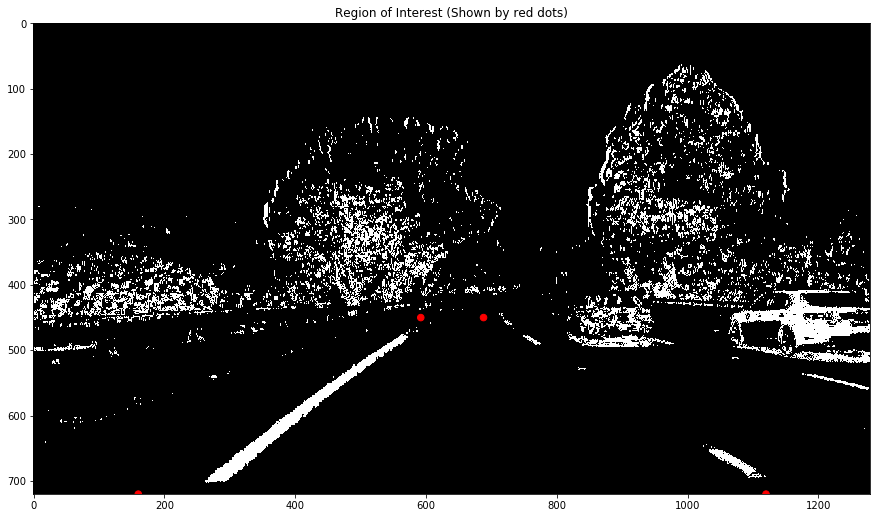

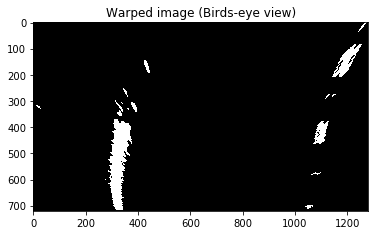

In [14]:
binary_warped, M, Minv = birds_eye_transform(binary, mtx, dist, showROI=True)
plt.imshow(binary_warped, cmap='gray')
plt.title("Warped image (Birds-eye view)")
plt.savefig("output_images/warped_image_birds_eye.jpg")

## Step 5: Detect lane pixels and fit to find the lane boundary
Now that we have the perspective transform, we can go ahead and find what pixels belong to what lane line. And eventually, find the equation of the curve (polynomial) for both lane lines.

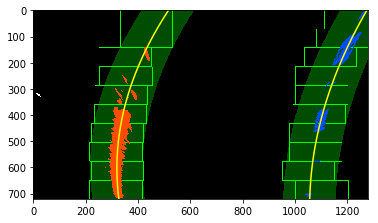

In [15]:
# Define conversions in x and y from pixels space to meters
xm_per_pix = 3.7/700 # meters per pixel in x dimension
ym_per_pix = 30/720 # meters per pixel in y dimension

lane_detected, left_fitx, right_fitx, ploty = detect_lane(binary_warped, xm_per_pix, True)
plt.imshow(lane_detected)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("output_images/warped_detected_lane.jpg")

## Step 6: Radius of Curvature
Once we get the equations of the two curved lanes, we can find the road's radius of curvature.

In [16]:
radius_of_curvature = get_radius_of_curvature(xm_per_pix, ym_per_pix)

## Step 7: Vehicle position
It is very important to remember that our car will not always be in the center of the lane. Thus, we find the relative position of the car with respect to the center of the lane.

In [17]:
difference, direction = get_vehicle_position(xm_per_pix, ym_per_pix)

## Step 8: Warp the detected lane boundaries back onto the original image
Now that we have all the information, let's invert back to the original image and mark the detected lane lines.

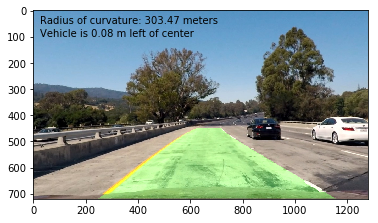

In [18]:
output = get_output(undistort_test_image)
plt.imshow(output)
plt.text(25, 50, "Radius of curvature: {0:.2f} meters".format(radius_of_curvature))
plt.text(25, 100, "Vehicle is {0:.2f} m {1} of center".format(difference, direction))
plt.savefig("output_images/final_output.jpg")

# Testing on Video
Now let's test our pipeline on a sample video to see if it can detect the lane line, radius of curvature of the road and the relative position of the car with respect to the center of the lane.

In [19]:
mtx, dist = calibrate_camera(False)

# Define conversions in x and y from pixels space to meters
xm_per_pix = 3.7/700 # meters per pixel in x dimension
ym_per_pix = 30/720 # meters per pixel in y dimension

video = cv2.VideoCapture("project_video.mp4")
first_image = True
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(video.get(3))
frame_height = int(video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('project_output.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 25, (frame_width,frame_height))

while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        undistort = undistort_image(frame, mtx, dist)
        binary = color_and_gradient_thresholding(undistort, output_mode='binary')
        binary_warped, M, Minv = birds_eye_transform(binary, mtx, dist, showROI=False)
        lane_detected, left_fitx, right_fitx, ploty = detect_lane(binary_warped, xm_per_pix, first_image)
        if(first_image):
            first_image = False
        radius_of_curvature = get_radius_of_curvature(xm_per_pix, ym_per_pix)
        difference, direction = get_vehicle_position(xm_per_pix, ym_per_pix)
        output = get_output(undistort)
        
        cv2.putText(output,"Radius of curvature: {0:.2f} meters".format(radius_of_curvature), (25,50), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
        cv2.putText(output,"Vehicle is {0:.2f} m {1} of center".format(difference, direction), (25,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
        out.write(output)
    # Break the loop
    else: 
        break

# When everything done, release the video capture and video write objects
video.release()
out.release()